In [18]:
import numpy as np
import pynbody as pb

In [19]:
def bar_align(galaxy, rbar, barfrac = 0.5, zlim=0.5, log=False):
    """
    Aligns the bar of pynbody galaxy simulation with the x-axis assuming the
    galaxy disc is already aligned to the XY plane using the inertial tensor.

    Function does not return any values/object. Pynbody functions effect the
    global variable which stores 'galaxy' so rotations within the functions
    are applied to input variable 'galaxy'.

    Parameters
    ----------
    galaxy : pynbody simulation object
        Galaxy object in the XY plane to be aligned.

    rbar : float
        Bar radius in simulation units e.g. kpc.

    barfrac : float
        Fraction of bar length to calculate the inertial tensor within in
        simulation units e.g. kpc.

    zlim : float
        Vertical limit to calculate intertial tensor within in simulation units
        e.g. kpc. Useful in galaxies with thick discs and weak bars.

    log : Bool
        Flag to output print statements.

    Returns
    -------
    None

    """
    if np.isnan(rbar):
        if log:
            print('* Bar undefined, using 1 kpc *')
        rbar = 1.0
    elif rbar*barfrac < 1.:
        rbar = 1
        if log:
            print('* Short Bar, using 1 kpc *')
    else:
        rbar = rbar*barfrac
        if log:
            print('* Bar defined, aligning to {} kpc *'.format(rbar))

    if log:
        print('* Realigning bar using |z| < {} *'.format(zlim))

    zfilt = pb.filt.LowPass('z',zlim)&pb.filt.HighPass('z',-zlim)
    rfilt = pb.filt.LowPass('rxy',rbar)

    x = np.array(galaxy[zfilt&rfilt].star['pos'].in_units('kpc'))[:,0]
    y = np.array(galaxy[zfilt&rfilt].star['pos'].in_units('kpc'))[:,1]
    m = np.array(galaxy.star[zfilt&rfilt]['mass'])

    #Calculate the inertia tensor
    I_yy, I_xx, I_xy = np.sum(m*y**2),np.sum(m*x**2),np.sum(m*x*y)
    I = np.array([[I_yy, -I_xy], [-I_xy, I_xx]])

    #Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(I)
    lowest = eigenvalues.argmin()
    maj_axis = eigenvectors[:, lowest]

    #Get the angle we need to rotate by
    r_angle = np.degrees(np.arctan2(maj_axis[1], maj_axis[0]))

    galaxy.rotate_z(-r_angle)

    if log:
        print('* Bar realigned by {} degrees*'.format(r_angle))

    return None

In [20]:
sim = pb.load('/Users/sgk/vault/data/708main/run708main.01000')

In [21]:
pb.analysis.angmom.faceon(sim)

SimArray([[136.48085 , 130.6039  , 124.72697 , ...,  54.003036,
            45.02071 ,  36.038387],
          [176.1024  , 155.56271 , 135.02301 , ...,  46.301224,
            40.35027 ,  34.399307],
          [215.72398 , 180.52155 , 145.31909 , ...,  38.599415,
            35.67982 ,  32.760223],
          ...,
          [ 50.33861 ,  84.98061 , 119.62266 , ..., 108.49482 ,
           105.82813 , 103.16144 ],
          [ 90.103096,  99.988174, 109.87326 , ..., 133.17241 ,
           130.62395 , 128.07549 ],
          [129.86757 , 114.995735, 100.12388 , ..., 157.85002 ,
           155.41977 , 152.98953 ]], dtype=float32, '2.36e+05 Msol kpc**-3')

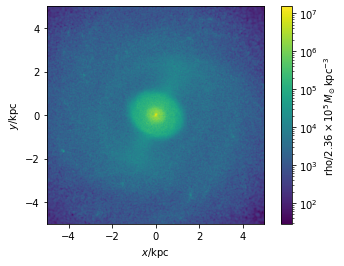

In [22]:
pb.plot.image(sim.s)

In [23]:
bar_align(sim,3.,barfrac=1.,zlim=0.5,log=True)

* Bar defined, aligning to 3.0 kpc *
* Realigning bar using |z| < 0.5 *
* Bar realigned by 63.251202786016385 degrees*


SimArray([[ 85.76656 ,  86.89603 ,  88.02552 , ..., 103.34578 ,
           108.53672 , 113.727684],
          [ 84.98111 ,  83.73258 ,  82.48405 , ...,  79.71765 ,
            87.637856,  95.558075],
          [ 84.195656,  80.56912 ,  76.94257 , ...,  56.089527,
            66.739006,  77.38849 ],
          ...,
          [ 97.171364,  95.4106  ,  93.64985 , ..., 216.18935 ,
           175.31802 , 134.44672 ],
          [102.96382 , 100.55571 ,  98.14759 , ..., 173.89801 ,
           144.94968 , 116.00136 ],
          [108.75627 , 105.700806, 102.645355, ..., 131.6067  ,
           114.581345,  97.556   ]], dtype=float32, '2.36e+05 Msol kpc**-3')

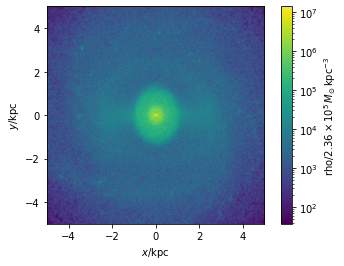

In [24]:
pb.plot.image(sim.s)